
## DAV 6150 -  Module 3 Assignment: Cleaning “Messy” Data (Wine Dataset)

**Team members: Alwyn Munatsi, Chidochashe Makanga, Lucia Shumba, Bekithemba Nkomo**  
**Course:** DAV 6150  
**Dataset:** `M3_Data.csv`



### 1) Introduction

We are working with a wine dataset that has some quality issues, including missing values, skewed distributions, and potential outliers.
The goal is to explore the data through EDA, clean and prepare it, and then re-examine the dataset after imputation to see how it changed.

Plan:

1. Load and inspect the dataset (structure, missingness, duplicates).

2. Run EDA to check distributions, skewness, and outliers.

3. Handle missing values using Kernel Density Estimation (PDF sampling) for numeric variables and mode imputation for categorical ones.

4. Re-run EDA on the cleaned dataset and compare before vs. after.

5. Summarize findings and make recommendations for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# url where the dataset is located
url = "https://raw.githubusercontent.com/chidochasherachael/DAV-6150/refs/heads/main/M3_Data.csv"

# Load dataset into pandas dataframe
df = pd.read_csv(url)

#Display the first few rows
df.head()


,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,0,8,2.0
1,2,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,-1,7,3.0
2,4,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,-1,8,3.0
3,5,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,-1,6,1.0
4,6,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,0,9,2.0



### 2) Exploratory Data Analysis 
#### 2.1 Schema, missingness, and duplicates

The schema summarizes the structure of the dataset: column names, data types, and non-null counts.  
This helps us identify potential issues such as missing values or unexpected data types.

In [2]:
# Check the shape of the dataset (rows, columns)
print("Dataset shape:", df.shape)

# General info (data types, non-null counts, memory usage)
df.info()


Dataset shape: (12795, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INDEX               12795 non-null  int64  
 1   TARGET              12795 non-null  int64  
 2   FixedAcidity        12795 non-null  float64
 3   VolatileAcidity     12795 non-null  float64
 4   CitricAcid          12795 non-null  float64
 5   ResidualSugar       12179 non-null  float64
 6   Chlorides           12157 non-null  float64
 7   FreeSulfurDioxide   12148 non-null  float64
 8   TotalSulfurDioxide  12113 non-null  float64
 9   Density             12795 non-null  float64
 10  pH                  12400 non-null  float64
 11  Sulphates           11585 non-null  float64
 12  Alcohol             12142 non-null  float64
 13  LabelAppeal         12795 non-null  int64  
 14  AcidIndex           12795 non-null  int64  
 15  STARS               9436 n

In [3]:
# Convert data types (change Index to String type, Stars to category and LabAppeal to category)

# Ensure INDEX is string (identifier, not numeric)
df["INDEX"] = df["INDEX"].astype(str)

# Treat categorical/ordinal as category
df["STARS"] = df["STARS"].astype("category")
df["LabelAppeal"] = df["LabelAppeal"].astype("category")

# Ensure numeric columns are float data type
numeric_cols = ["Alcohol", "Chlorides", "CitricAcid", "Density", 
                "FixedAcidity", "FreeSulfurDioxide", "ResidualSugar", 
                "Sulphates", "TotalSulfurDioxide", "VolatileAcidity", 
                "pH", "AcidIndex", "TARGET"]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.dtypes

INDEX                   object
TARGET                   int64
FixedAcidity           float64
VolatileAcidity        float64
CitricAcid             float64
ResidualSugar          float64
Chlorides              float64
FreeSulfurDioxide      float64
TotalSulfurDioxide     float64
Density                float64
pH                     float64
Sulphates              float64
Alcohol                float64
LabelAppeal           category
AcidIndex                int64
STARS                 category
dtype: object

In [4]:
# Change column names to lowercase

import re    #regex library

def camel_to_snake(name):
    # If the whole column name is uppercase or mixed lowercase and uppErcase (like TARGET, INDEX, pH)
    if name.isupper() or name == "pH":
        return name.lower()
    # Otherwise, convert CamelCase/PascalCase to snake_case
    name = re.sub(r'(?<!^)(?=[A-Z])', '_', name)
    return name.lower()

# Apply to all columns
df.columns = [camel_to_snake(col) for col in df.columns]

print("Updated column names:")
print(df.columns.tolist())

Updated column names:
['index', 'target', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'ph', 'sulphates', 'alcohol', 'label_appeal', 'acid_index', 'stars']


In [5]:
# Missing values per column (descending)
df.isna().sum().sort_values(ascending=False)

stars                   3359
sulphates               1210
total_sulfur_dioxide     682
alcohol                  653
free_sulfur_dioxide      647
chlorides                638
residual_sugar           616
ph                       395
citric_acid                0
target                     0
fixed_acidity              0
volatile_acidity           0
index                      0
density                    0
label_appeal               0
acid_index                 0
dtype: int64

In [6]:
# Duplicate rows
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0



#### 2.2 Summary statistics (numeric)


In [7]:
# Get numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Summary stats (transposed for readability)
df[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
target,12795.0,3.029074,1.926368,0.00000,2.00000,3.00000,4.000000,8.00000
fixed_acidity,12795.0,7.075717,6.317643,-18.10000,5.20000,6.90000,9.500000,34.40000
volatile_acidity,12795.0,0.324104,0.784014,-2.79000,0.13000,0.28000,0.640000,3.68000
citric_acid,12795.0,0.308413,0.862080,-3.24000,0.03000,0.31000,0.580000,3.86000
residual_sugar,12179.0,5.418733,33.749379,-127.80000,-2.00000,3.90000,15.900000,141.15000
chlorides,12157.0,0.054822,0.318467,-1.17100,-0.03100,0.04600,0.153000,1.35100
free_sulfur_dioxide,12148.0,30.845571,148.714558,-555.00000,0.00000,30.00000,70.000000,623.00000
total_sulfur_dioxide,12113.0,120.714233,231.913211,-823.00000,27.00000,123.00000,208.000000,1057.00000
density,12795.0,0.994203,0.026538,0.88809,0.98772,0.99449,1.000515,1.09924
ph,12400.0,3.207628,0.679687,0.48000,2.96000,3.20000,3.470000,6.13000



#### 2.3 Distribution shape: skewness


In [8]:
# Skewness: 0 = symmetric, +ve = right-skew, -ve = left-skew

# Sort numeric features by skew (most positive first)
skewness = df[num_cols].skew(numeric_only=True).sort_values(ascending=False)

skewness

acid_index              1.648883
ph                      0.044299
chlorides               0.030435
volatile_acidity        0.020385
free_sulfur_dioxide     0.006395
sulphates               0.005913
total_sulfur_dioxide   -0.007181
density                -0.018698
fixed_acidity          -0.022591
alcohol                -0.030723
citric_acid            -0.050319
residual_sugar         -0.053136
target                 -0.326378
dtype: float64


#### 2.4 Visuals: histograms and boxplots and heatmap
In the histogram loop, missing values are removed via `.dropna()` to allow clean visualization of the distributions.This of course does not resolve missingness but ensures plots reflect only valid data.  Formal handling of missing values is performed later in the Data Preparation step.

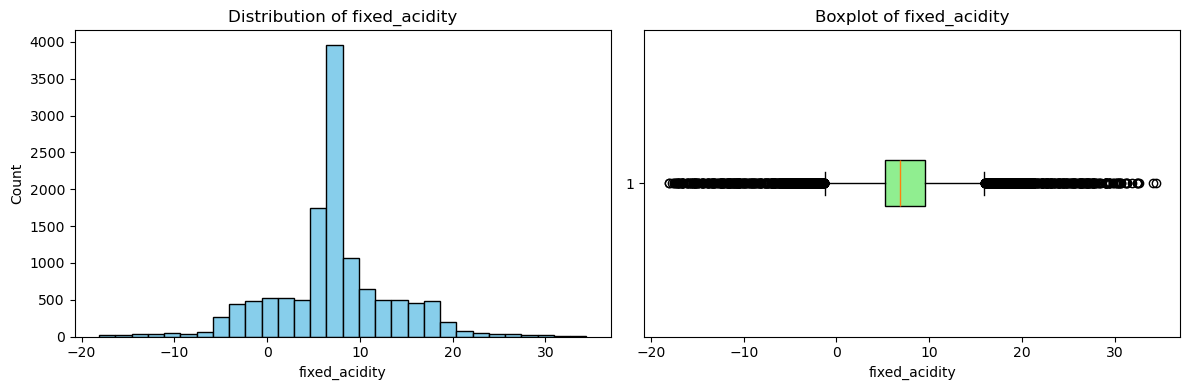

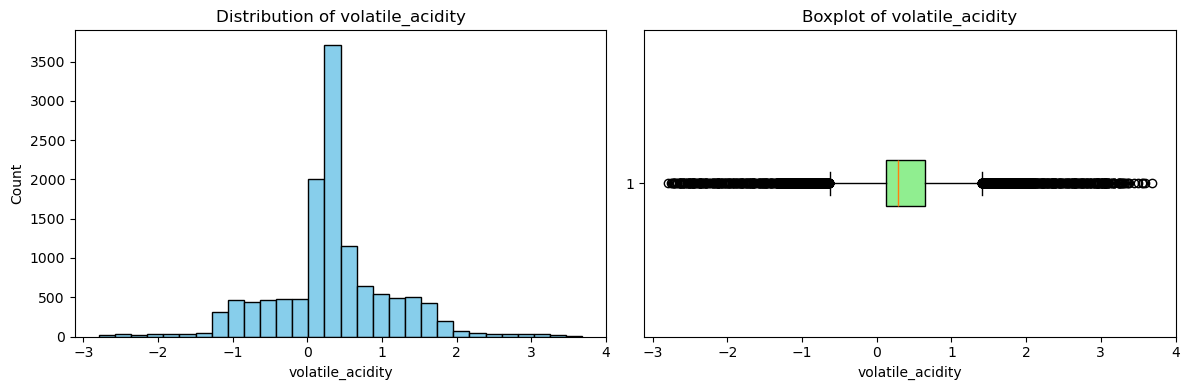

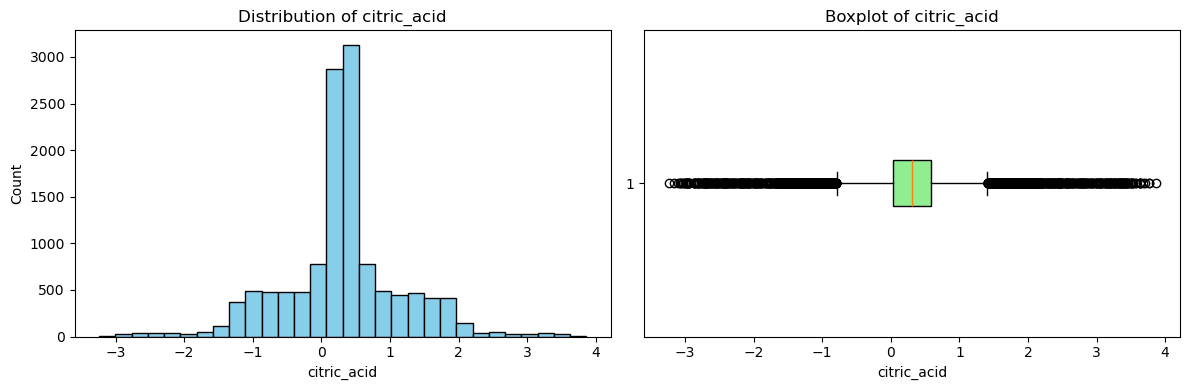

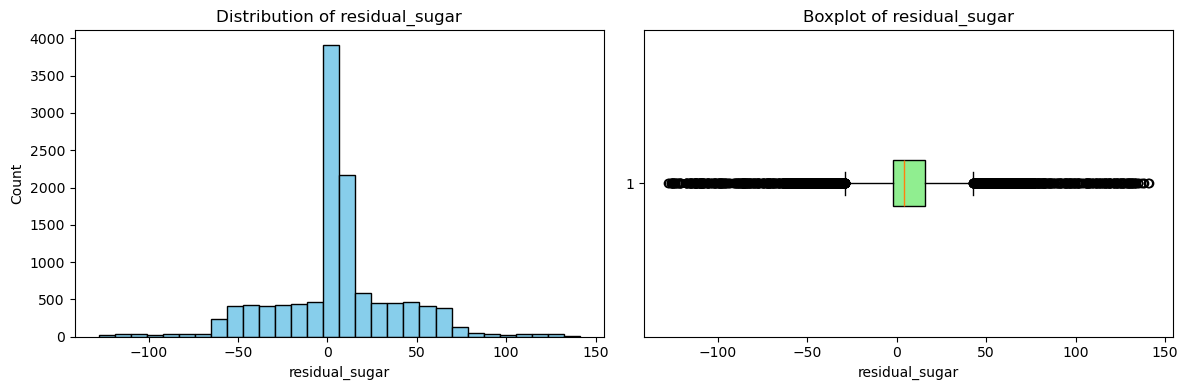

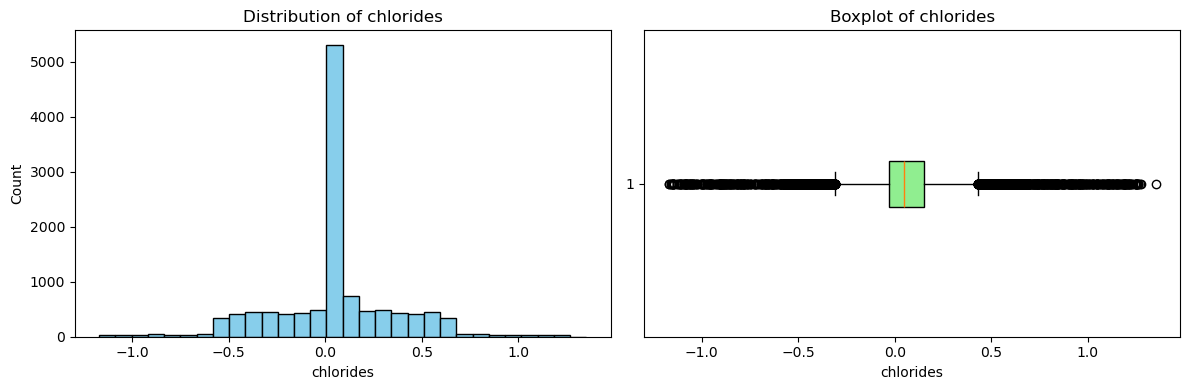

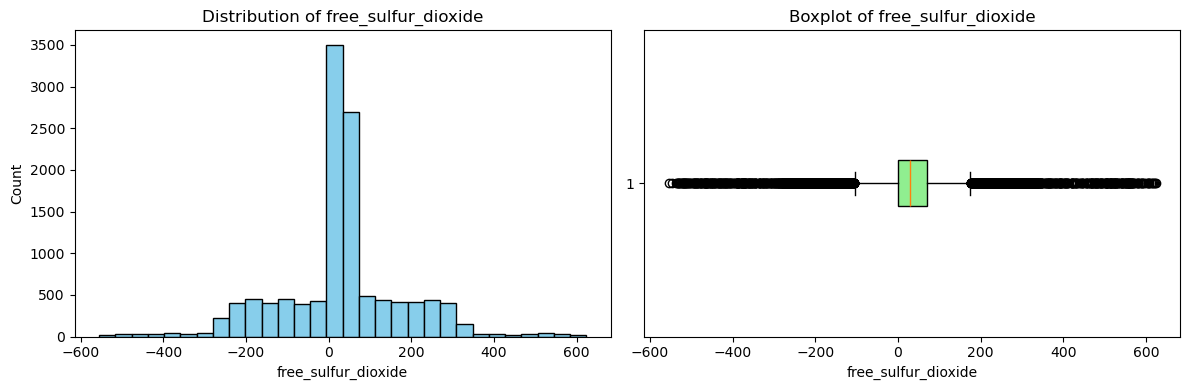

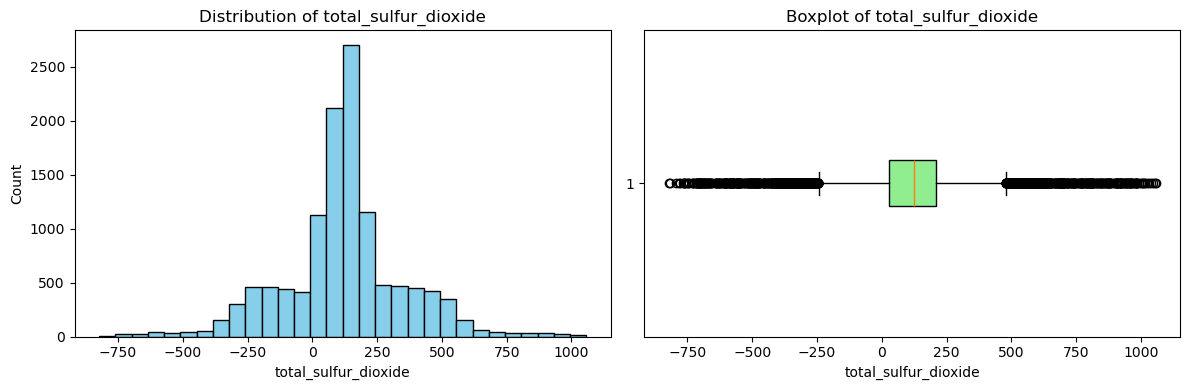

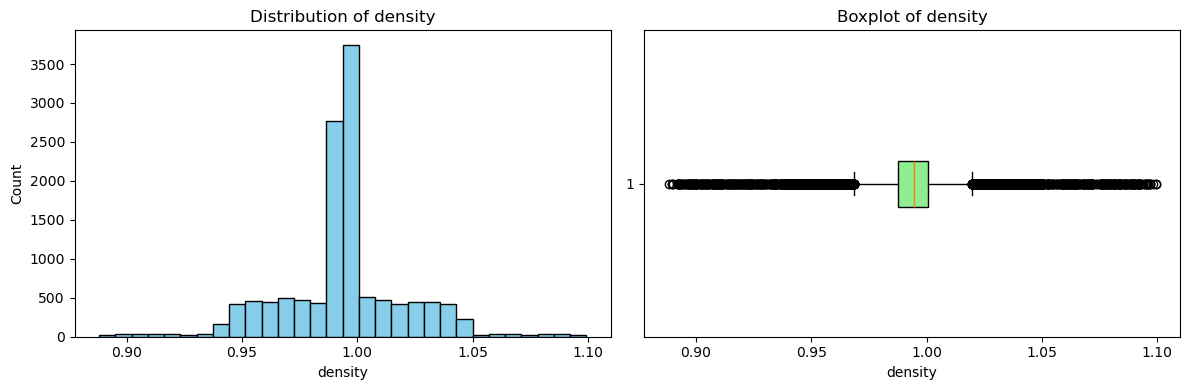

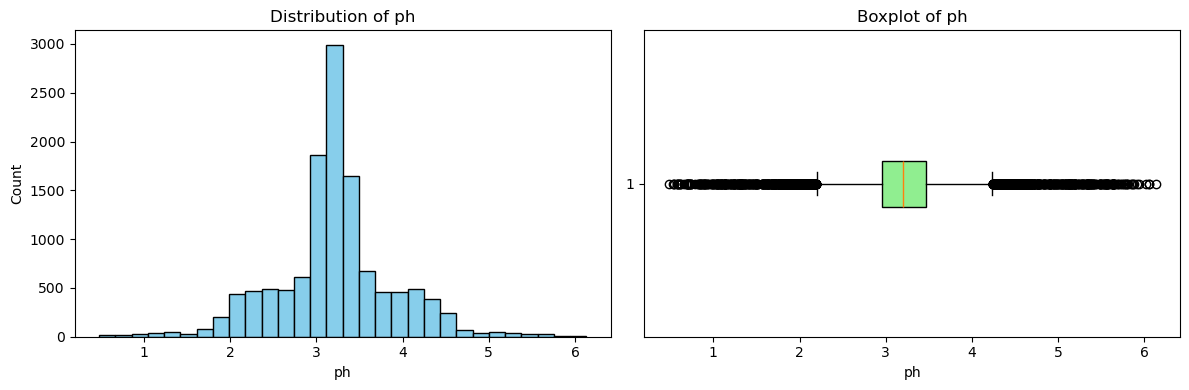

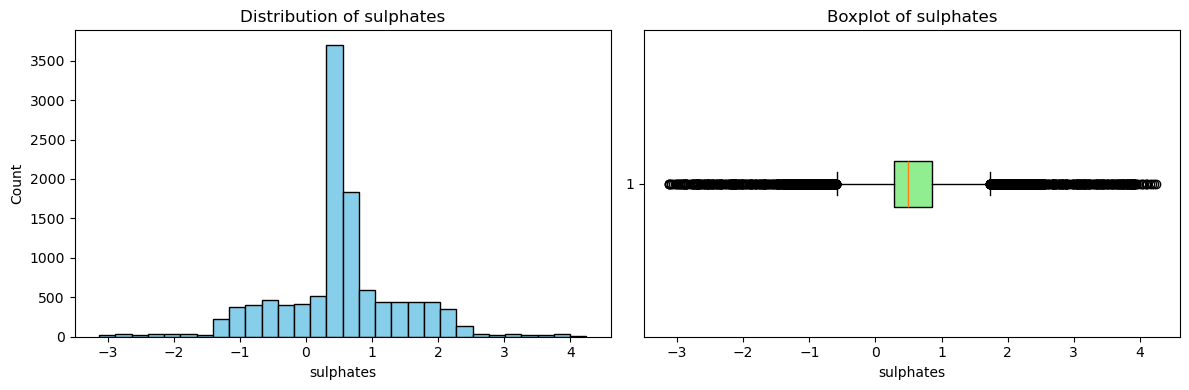

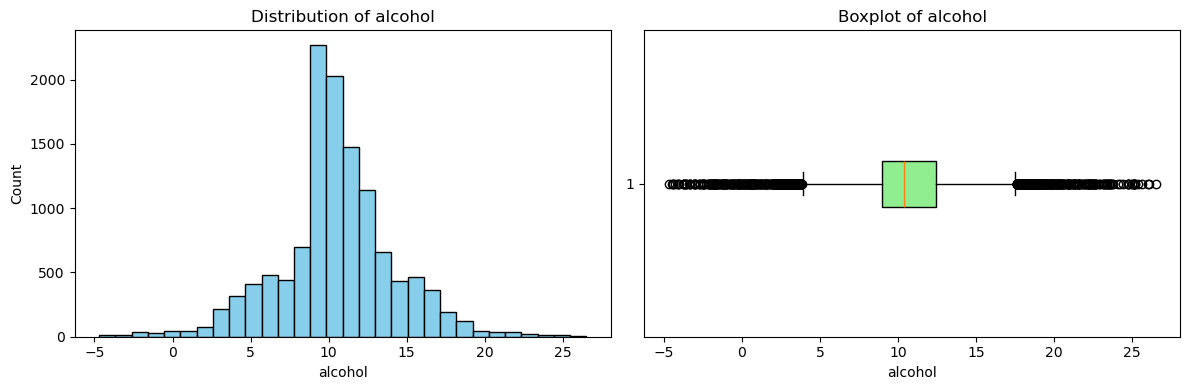

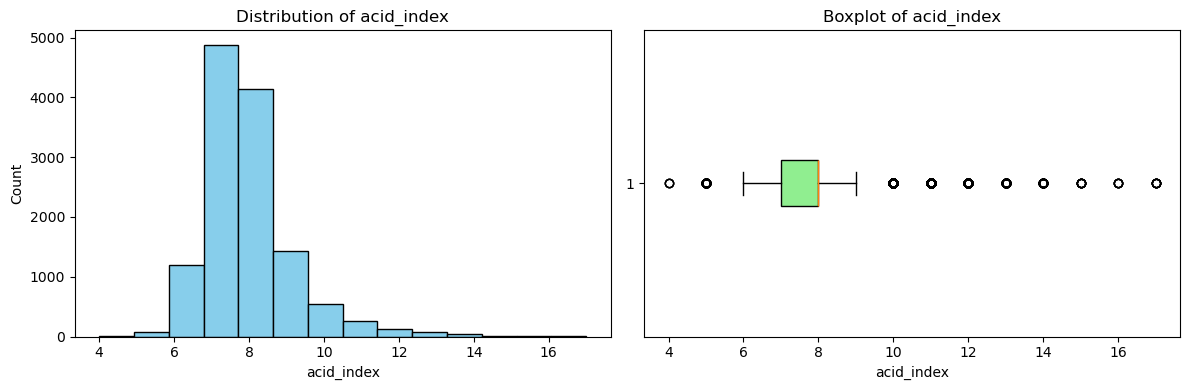

In [9]:
plot_cols = [c for c in num_cols if c not in ["target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Decide bins: fewer for discrete-like variables, more for continuous
    n_unique = df[col].nunique()
    if n_unique < 20:
        bins = n_unique   # one bin per unique value (good for discrete values like citric_acid )
    else:
        bins = 30         # default for continuous variables

    # Histogram
    axes[0].hist(df[col].dropna(), bins=bins, color="skyblue", edgecolor="black")
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Count")

    # Boxplot
    axes[1].boxplot(df[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor="lightgreen"))
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()


The categorical/ordinal variables (`target`, `label_appeal`, `stars`) were visualized with bar plots.  
- `target` shows how many wines fall into each sales category.  
- `label_appeal` shows the distribution of marketing scores.  
- `stars` shows the distribution of expert ratings.  

These variables are ordinal, so bar plots provide clearer insights than histograms or boxplots.


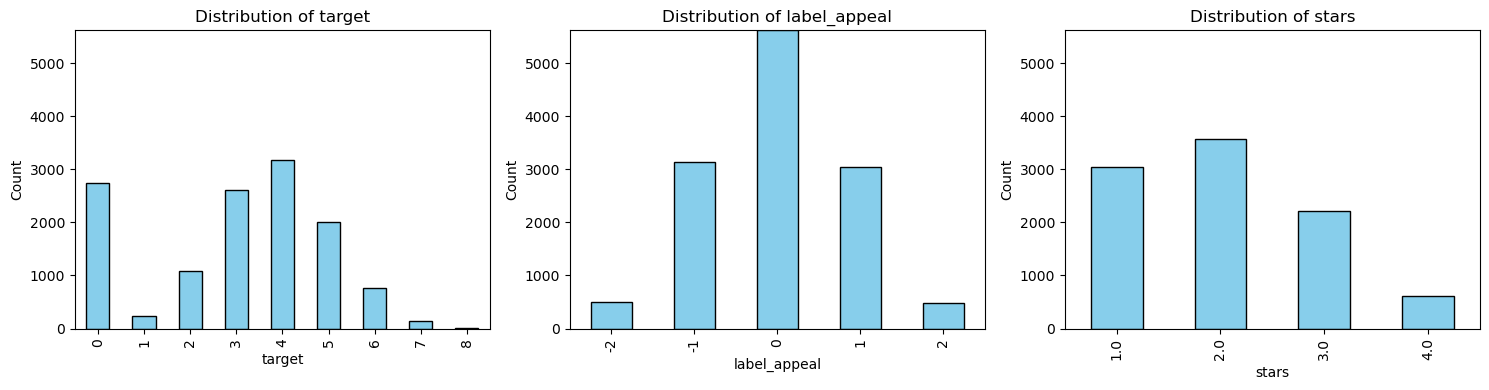

In [10]:
import matplotlib.pyplot as plt

# Define categorical/ordinal variables
cat_cols = ["target", "label_appeal", "stars"]

# Find max frequency across all categorical columns (for consistent y-axis)
max_count = max(df[c].value_counts().max() for c in cat_cols)

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(cat_cols):
    df[col].value_counts().sort_index().plot(
        kind="bar",
        color="skyblue",
        edgecolor="black",
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].set_ylim(0, max_count)  # consistent y-axis across all

plt.tight_layout()
plt.show()



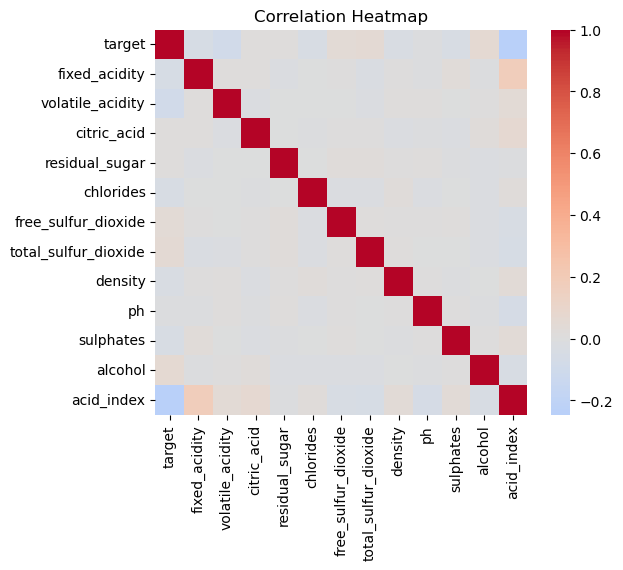

In [11]:
# Correlation heatmap 
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


#### 2.5 Sanity checks for invalid values (domain‑agnostic)


In [12]:
# Keep only continuous numeric features
check_cols = [c for c in num_cols] 
#if c not in "target"]

# Build invalid report only for relevant features
invalid_report = {}
for col in check_cols:
    s = df[col]
    invalid_report[col] = {
        "negatives": int((s < 0).sum()),       # count of negative values
        "zeros": int((s == 0).sum()),          # count of zeros
        "p99_value": float(s.quantile(0.99))   # 99th percentile
    }

# Convert to DataFrame for readability
pd.DataFrame(invalid_report).T.sort_index()



,negatives,zeros,p99_value
acid_index,0.0,0.0,13.000000
alcohol,118.0,2.0,20.300000
chlorides,3197.0,5.0,0.957000
citric_acid,2966.0,115.0,2.660000
density,0.0,0.0,1.069359
fixed_acidity,1621.0,39.0,24.306000
free_sulfur_dioxide,3036.0,11.0,469.000000
ph,0.0,0.0,5.120100
residual_sugar,3136.0,6.0,98.810000
sulphates,2361.0,22.0,3.151600


### 3) Data Preparation
Firstly, we are going to replace all negative values in numeric columns with (NaN), since values like negative alcohol percentage or negative sugar are not chemically valid. This applies to columns such as Alcohol, ResidualSugar, Sulphates, Chlorides, CitricAcid, FixedAcidity, FreeSulfurDioxide, TotalSulfurDioxide, and VolatileAcidity.

After this, we apply our imputation methods: numeric variables are imputed using Probability Density Function (PDF)-based imputation with Kernel Density Estimation (KDE), which preserves the shape and skewness of the data, and categorical variables (Target, LabelAppeal, Stars) are imputed using the mode (most frequent category) to keep values valid and interpretable.


In [13]:
# Step 1: Replace negative values in numeric columns with NaN
for col in num_cols:
    df.loc[df[col] < 0, col] = np.nan

# Quick check: count how many NaNs you now have per column
print(df.isna().sum().sort_values(ascending=False))


chlorides               3835
residual_sugar          3752
free_sulfur_dioxide     3683
sulphates               3571
stars                   3359
total_sulfur_dioxide    3186
citric_acid             2966
volatile_acidity        2827
fixed_acidity           1621
alcohol                  771
ph                       395
index                      0
target                     0
density                    0
label_appeal               0
acid_index                 0
dtype: int64


In [14]:
from scipy.stats import gaussian_kde
import numpy as np

# Identify numeric / categorical cols
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in ["target", "label_appeal", "stars"] if c in df.columns]

# Numeric imputation: KDE (Probability Density Function) 
for col in num_cols:
    miss_mask = df[col].isna()
    n_miss = miss_mask.sum()
    if n_miss == 0:
        continue

    observed = df[col].dropna().to_numpy()

    # Handle edge cases
    if observed.size == 0:
        df.loc[miss_mask, col] = 0.0
        continue
    if np.allclose(observed, observed[0]):  # all values identical
        df.loc[miss_mask, col] = observed[0]
        continue

    # Fit KDE and sample
    kde = gaussian_kde(observed)
    imputed = kde.resample(n_miss).flatten()

    # Optional: clip negatives if variable must be ≥0
    imputed = np.clip(imputed, 0, None)

    df.loc[miss_mask, col] = imputed

#Categorical imputation: mode 
for col in cat_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].mode(dropna=True)[0], inplace=True)

# Confirm no missing values remain
print("Missing values after imputation:")
print(df.isna().sum().sort_values(ascending=False))

# Save cleaned file
clean_path = "M3_Data_clean.csv"
df.to_csv(clean_path, index=False)
print(f"\nSaved cleaned data to: {clean_path}")


Missing values after imputation:
index                   0
target                  0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
label_appeal            0
acid_index              0
stars                   0
dtype: int64


C:\Users\Chido\AppData\Local\Temp\ipykernel_2344\547449154.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode(dropna=True)[0], inplace=True)



Saved cleaned data to: M3_Data_clean.csv


### 4) Prepped Data Review - Post-Data Prep EDA analysis.

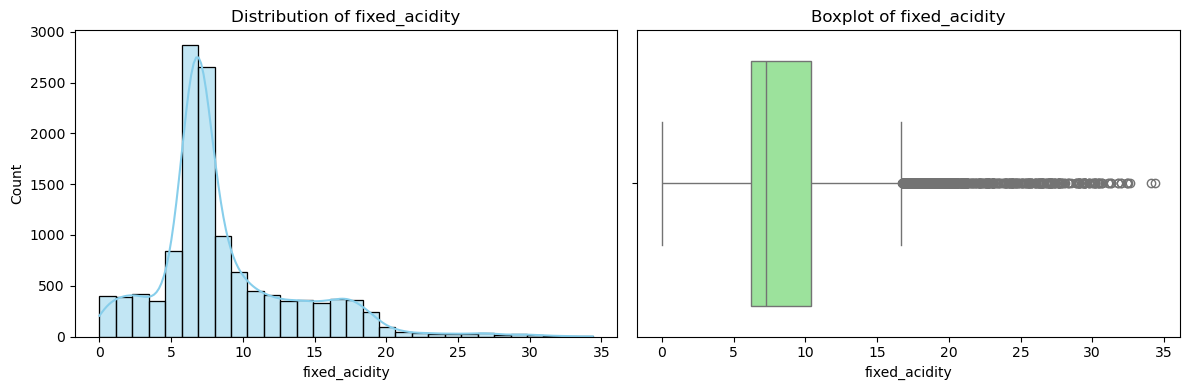

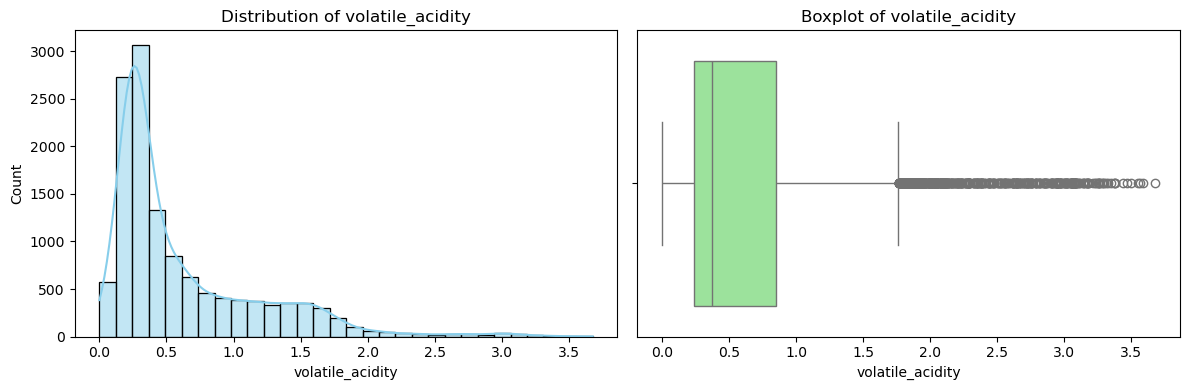

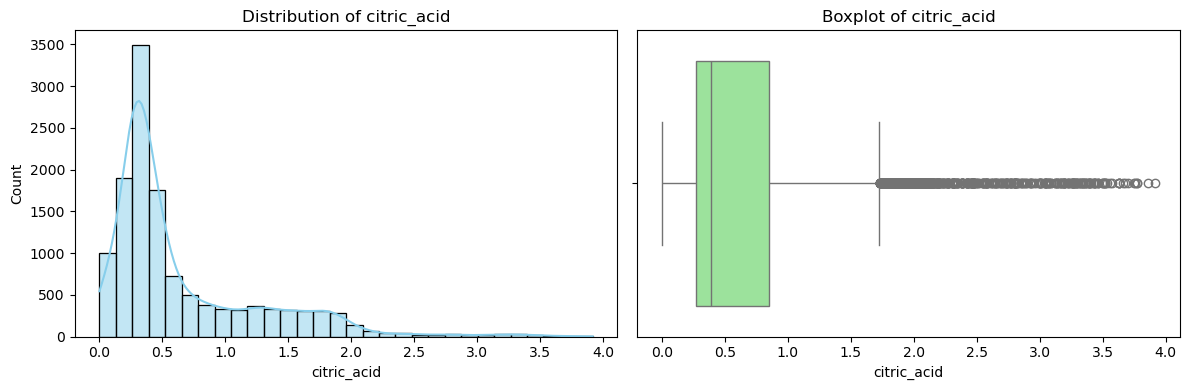

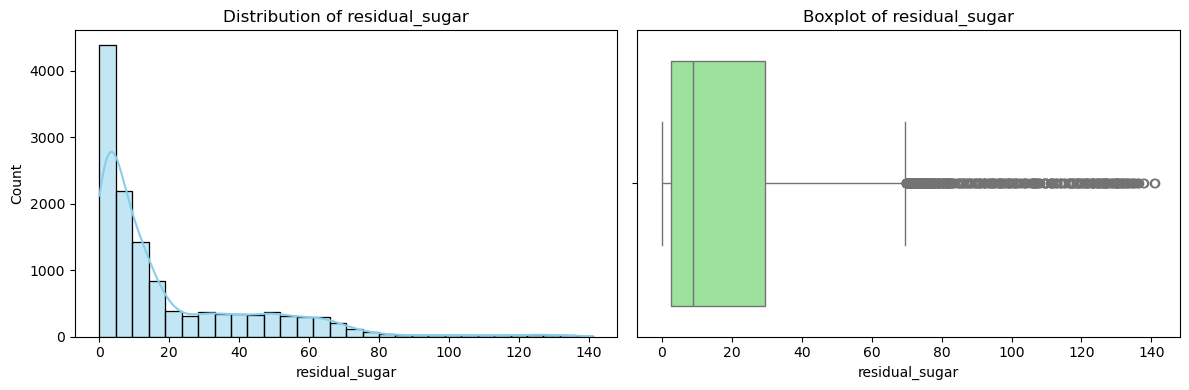

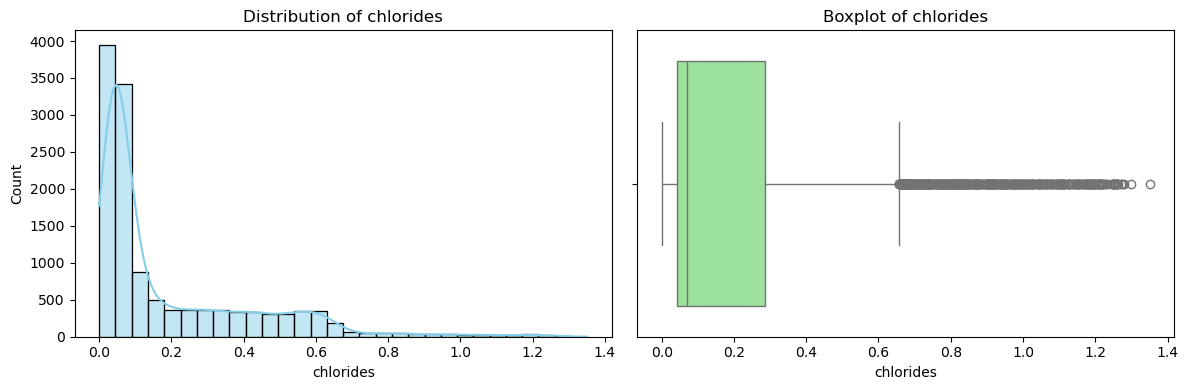

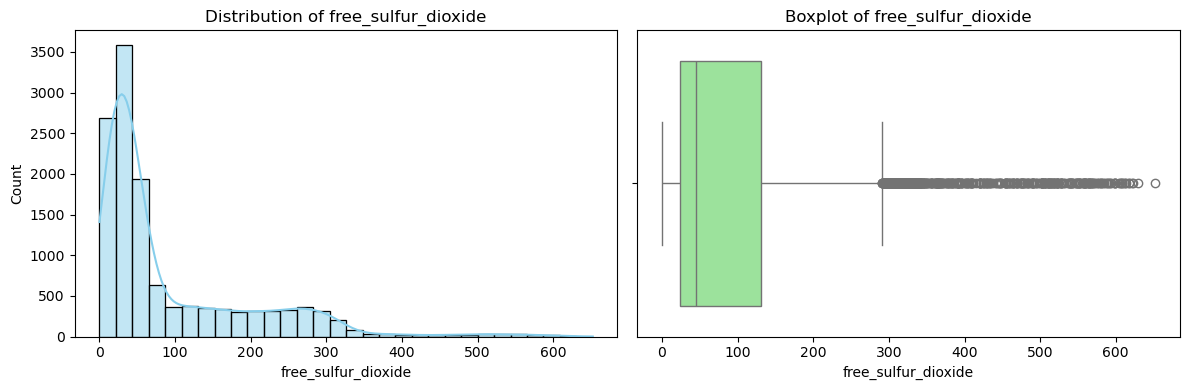

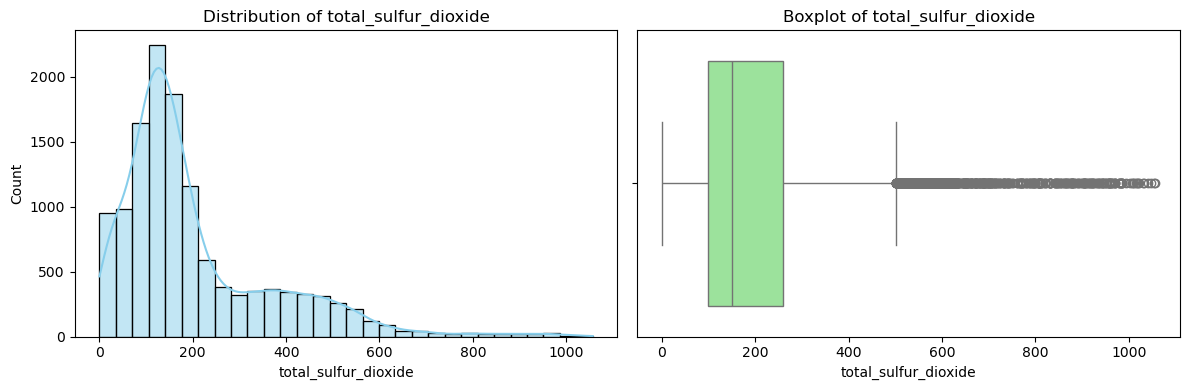

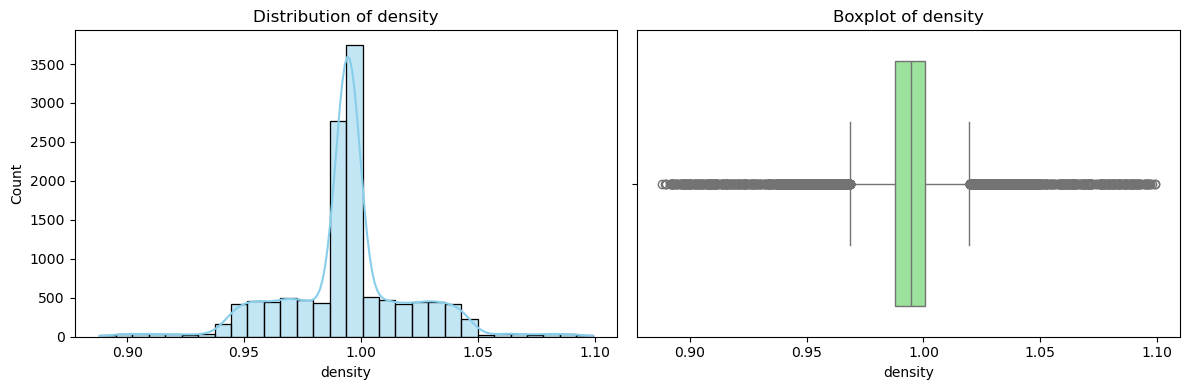

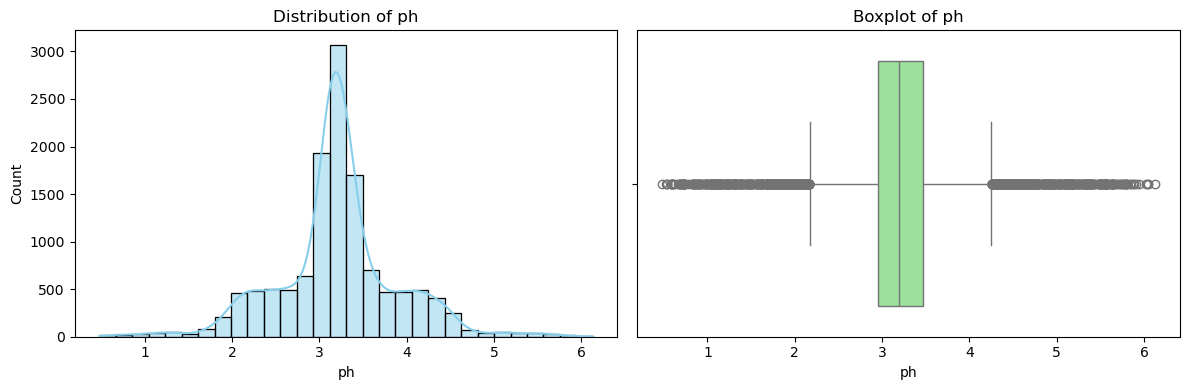

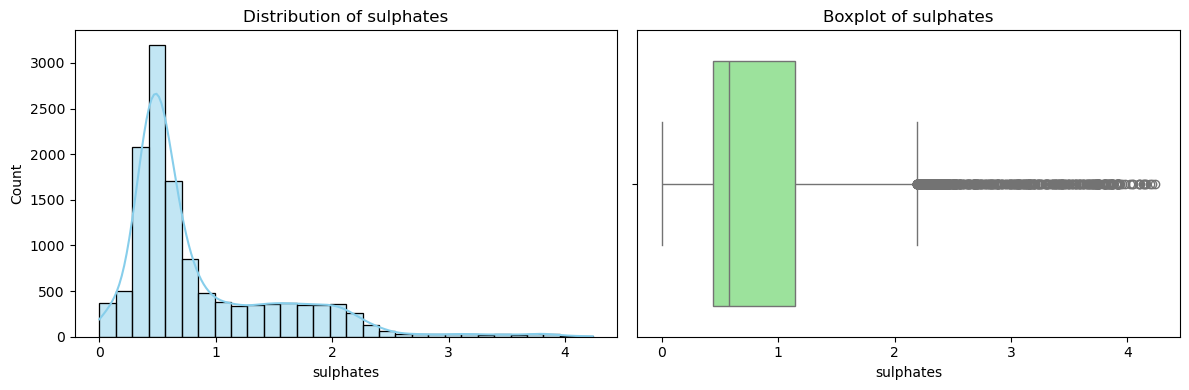

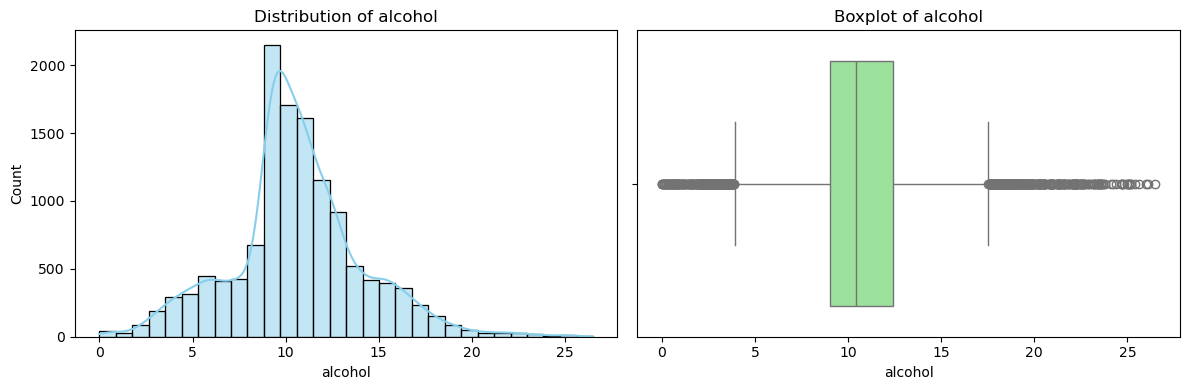

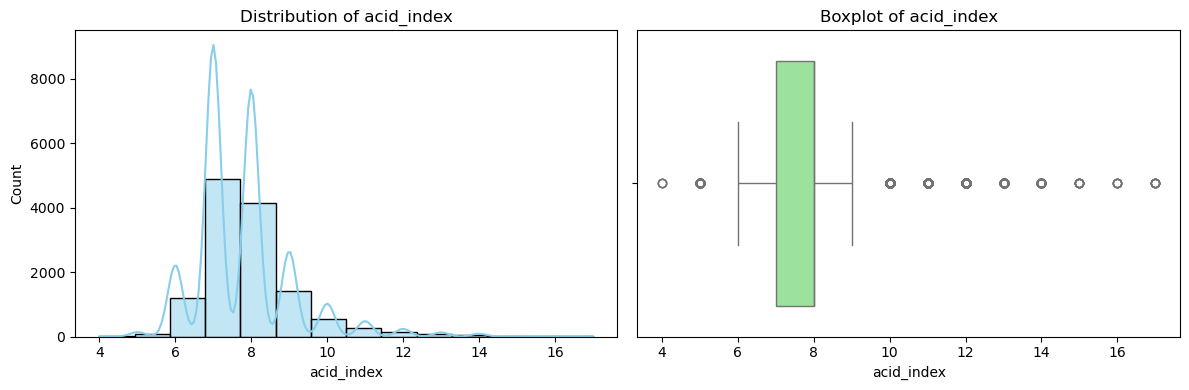

In [15]:
# Histograms and boxplots for all numeric cols

plot_cols = [c for c in num_cols if c not in ["target"]]

for col in plot_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Decide bins: fewer for discrete-like variables, 30 for continuous
    n_unique = df[col].nunique()
    bins = n_unique if n_unique < 20 else 30

    # Histogram
    sns.histplot(df[col], bins=bins, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Count")

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[1], color="lightgreen")
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

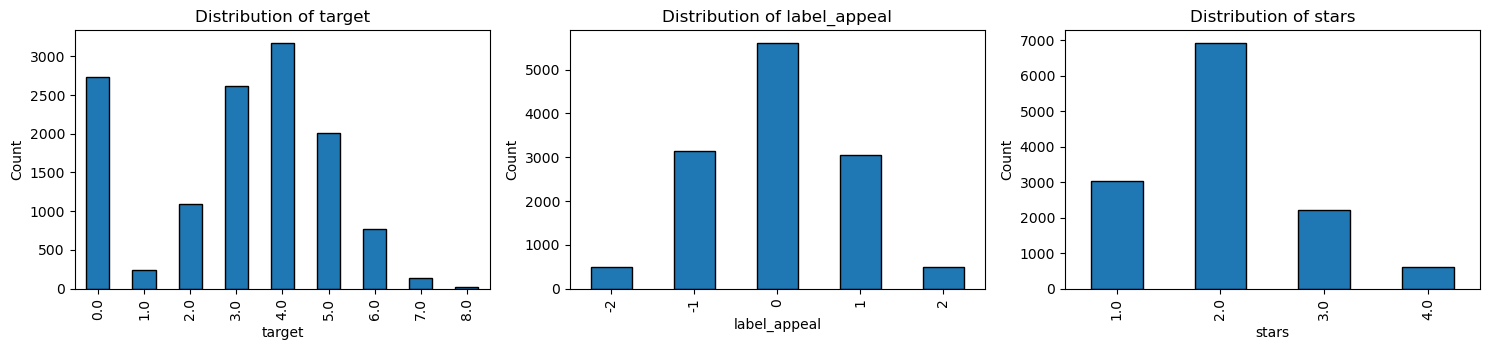

In [16]:
# Categoricals: side-by-side bar charts 
if cat_cols:
    max_count = max(df[c].value_counts().max() for c in cat_cols)
    fig, axes = plt.subplots(1, len(cat_cols), figsize=(5*len(cat_cols), 3.6))
    if len(cat_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, cat_cols):
        df[col].value_counts().sort_index().plot(kind="bar", ax=ax, edgecolor="black")
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col); ax.set_ylabel("Count")
        
    plt.tight_layout()
    plt.show()


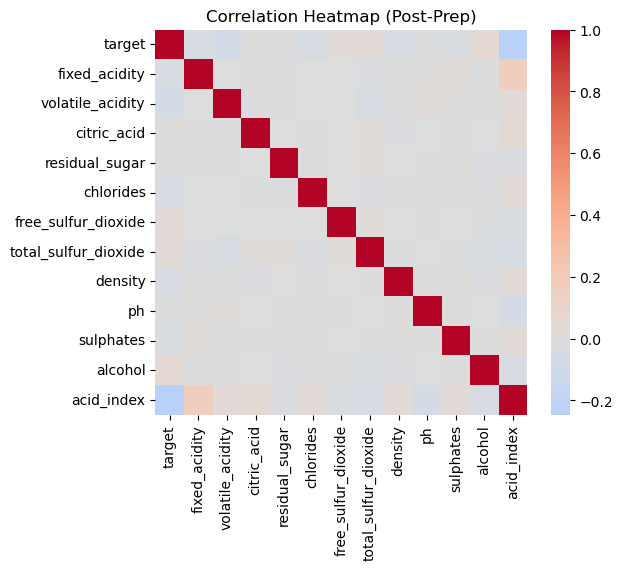

In [17]:
# Correlation heatmap (compact)
if len(num_cols) > 1:
    plt.figure(figsize=(6, 5))
    corr = df[num_cols].corr()
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (Post-Prep)")
    plt.show()


#### Conclusions & Modeling Recommendations

After cleaning, all missing values were handled. For numeric columns, negative values (like alcohol or residual sugar) were treated as invalid and replaced with NaN, then imputed using Kernel Density Estimation (PDF sampling). This kept the distributions realistic and avoided flat imputation. For categorical features (target, label_appeal, stars), we used mode imputation to keep values valid.

The overall distributions of the variables stayed similar before and after prep, but many numeric features are still right-skewed with outliers (e.g., residual sugar, sulfur dioxide). These are expected in real wine data, so we kept them. Correlation analysis showed that most variables are independent, with the only noticeable relationship between acid_index and fixed_acidity. The target variable is imbalanced, meaning some sales categories dominate.

Recommendations: 
Because of the skewness and outliers, I recommend using a tree-based model such as Random Forest or Gradient Boosting. These models can handle non-normal distributions and outliers without extra preprocessing. Logistic Regression can still be tried as a simple baseline, but it may struggle since the predictors are not normally distributed. For evaluation, I would rely on ROC-AUC or F1-score instead of plain accuracy, since the target imbalance could make accuracy misleading.